## Antônio Esteves - Avaliação de Cientista de Dados

### Q5: É possível estimar quanto de faturamento a Hotmart irá fazer nos próximos três meses a partir do último mês mostrado no dataset?

* https://www.youtube.com/watch?v=1m9u10eJ3Mk&ab_channel=Let%27sData
* https://www.kaggle.com/code/sumi25/understand-arima-and-tune-p-d-q/notebook
* https://www.kaggle.com/code/ludovicocuoghi/electric-production-forecast-lstm-sarima-mape-2-5/notebook
* https://www.machinelearningplus.com/time-series/time-series-analysis-python/

Para estimar quanto de faturamento a Hotmart irá fazer nos proximos meses, precisaremos modelar uma série temporal considerando o total compras ao longo de um período de tempo.

In [45]:
import random
import pandas as pd
import numpy as np

from scipy import stats
import scipy.stats as sct
import seaborn as sns
import statsmodels.api as sm
import itertools
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima

import scipy.stats as sct

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

from IPython.core.pylabtools import figsize
figsize(20, 8)

import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", 50)

In [4]:
filename = "data/sales_data.csv" 

total_rows = sum(1 for line in open(filename))-1                               
sample     = total_rows//10                                                    
skip       = sorted(random.sample(range(1, total_rows+1), total_rows-sample))

In [5]:
data = pd.read_csv(filename, skiprows=skip, parse_dates=['purchase_date', 'product_creation_date'])
data = data.drop(data.index[0])
data.shape

(159981, 14)

In [6]:
df = data.copy()

## Analisando os Dados

In [7]:
df.head()

,purchase_id,product_id,affiliate_id,producer_id,buyer_id,purchase_date,product_creation_date,product_category,product_niche,purchase_value,affiliate_commission_percentual,purchase_device,purchase_origin,is_origin_page_social_network
1,2017442,36468,186897,186897,1252324,2016-06-26 12:00:00,2012-06-25 19:29:42,Podcast,Presentation skills,-0.472931,0.0,Smart TV,Origin ef2b,"0,0"
2,2017884,53664,91695,91695,1436275,2016-06-26 12:00:00,2013-03-02 13:47:47,Phisical book,Anxiety management,-0.283435,0.0,Smart TV,Origin ef2b,"0,0"
3,3985785,90309,1008255,1008255,397434,2016-06-26 12:00:00,2014-03-10 09:48:43,Phisical book,Presentation skills,-0.539363,0.0,Smart TV,Origin ef2b,"0,0"
4,4915727,80572,365861,365861,405236,2016-06-26 12:00:00,2013-12-29 16:47:31,Phisical book,Filmmaking,-0.171445,0.0,Smart TV,Origin ef2b,"0,0"
5,5044531,108979,970510,970510,1443700,2016-06-26 12:00:00,2014-07-14 07:12:43,Podcast,Government,-0.517776,0.0,Smart TV,Origin ef2b,"0,0"


In [8]:
f"Data de compra mais antiga: {df['purchase_date'].min()}."

'Data de compra mais antiga: 2016-01-01 00:05:27.'

In [9]:
f"Data de compra mais recente: {df['purchase_date'].max()}."

'Data de compra mais recente: 2016-06-30 23:59:31.'

Vamos agora agrupar a vendas pelo total faturado e definir o índice dos nossos dados como a data da venda. Ao trabalhar com dados de séries temporais no Python, devemos garantir que as datas sejam usadas como um índice.

In [10]:
grouped_purchases = df[['purchase_value','purchase_date']].groupby('purchase_date')['purchase_value'].sum().reset_index()
grouped_purchases['purchase_date'] = pd.to_datetime(grouped_purchases['purchase_date'].dt.date)

In [11]:
grouped_purchases

,purchase_date,purchase_value
0,2016-01-01,0.204131
1,2016-01-01,-0.475728
2,2016-01-01,-0.171445
3,2016-01-01,-0.333254
4,2016-01-01,0.549448
...,...,...
158759,2016-06-30,-0.494368
158760,2016-06-30,-0.108974
158761,2016-06-30,-0.509329
158762,2016-06-30,1.517970


In [12]:
grouped_purchases = grouped_purchases.set_index(grouped_purchases['purchase_date'])
purchases         = grouped_purchases['purchase_value'].resample('D').sum()

In [13]:
purchases

purchase_date
2016-01-01   -106.238993
2016-01-02   -138.173856
2016-01-03   -138.183543
2016-01-04   -151.563772
2016-01-05   -143.150223
                 ...    
2016-06-26      7.402625
2016-06-27    -78.360963
2016-06-28   -101.940906
2016-06-29    -77.042096
2016-06-30      9.928965
Freq: D, Name: purchase_value, Length: 182, dtype: float64

Vamos observar vendas se comportam ao longo do ano e se apresentam alguma tendência.

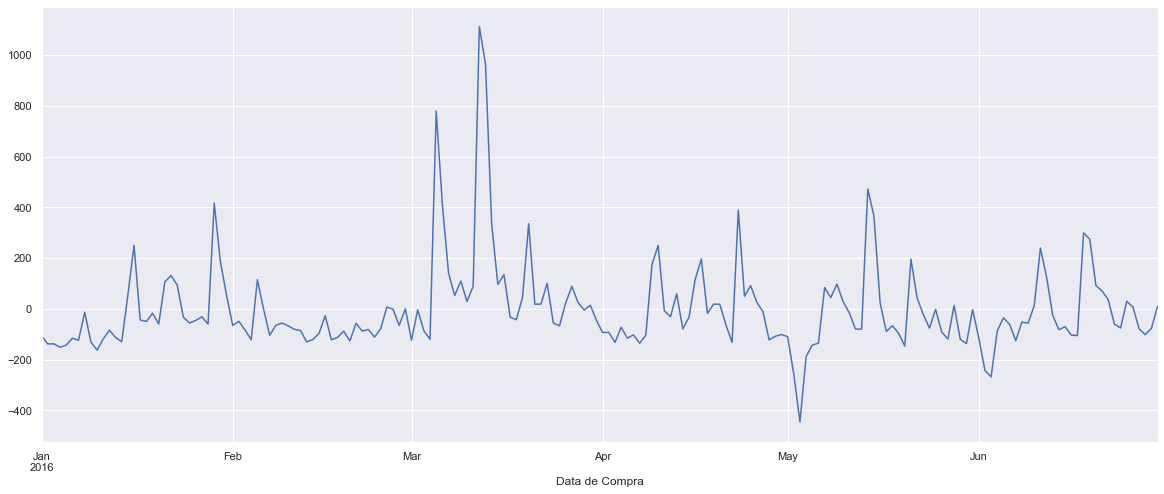

In [21]:
purchases.plot(grid=True);

plt.savefig("images/purchase_time_series.png", bbox_inches='tight')

plt.xlabel('Data de Compra');

As vendas ao longo de 2016 apresenam uma série temporal é estacionária, que oscila bastante ao longo do tempo. Podemos extrair alguns insights possíveis:

- Estamos diante de uma série temporal estacionária cujas propriedades estatísticas, como média, variância e autocorrelação, são todas constantes ao longo do tempo. Isso é confimado pelo fato que, embora haja altos e baixos em todos os momentos, visualmente não existem tendências ou sazonalidades óbvias.

- Também podemos observar como os altos e baixos não seguem uma regularidade.

- Apesar da alta oscilação da série, observamos que as vendas são sempre baixas no início dos meses, se sobressaem em picos no meio do mês e terminam o mês em baixa novamente (exceto para o mês de fevereiro).
 
- A variação da temporal não muda significativamente em relação aos diferentes intervalos da série temporal (Modelo Aditivo).

## Testes Estatísticos

Vamos conferir a normalidade dessa série, executando um teste de normalidade (ao nível de **significância de 5%**).

In [22]:
alpha = 0.05
stats, p_value = sct.normaltest(purchases)
if p_value > alpha:
    print('A série é Gaussiana (falha ao rejeitar H0)')
else:
    print('A série não é Gaussiana (rejeitamos H0)')

A série não é Gaussiana (rejeitamos H0)


Um outro teste possível é o teste de **Dickey-Fuller Aumentado** ou teste de raiz unitária que tem por objetivo determinar com que intensidade uma série temporal é definida por uma tendência. 
Assim vamos definir o tste da seguinte forma: a hipótese nula do teste é que a série temporal pode ser representada por uma raiz unitária, que não é estacionária (possui alguma estrutura dependente do tempo). A hipótese alternativa (rejeitando a hipótese nula) é que a série temporal é estacionária.

($H_0$) : Sugere que a série temporal tenha uma raiz unitária (não é estacionária) ou seja, tem alguma estrutura dependente do tempo.

($H1$) : Sugere que a série temporal não tem uma raiz unitária (é estacionária) ou seja, não possui estrutura dependente do tempo.

 - Valor $\textit{p}$ > 0,05 : falha ao rejeitar a hipótese nula ($H_0$)
 - Valor de $\textit{p}$ <= 0,05 : Rejeita a hipótese nula ($H_0$)

In [23]:
X = purchases.values
result = adfuller(X)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Valores Críticos:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.534740
p-value: 0.007138
Valores Críticos:
	1%: -3.469
	5%: -2.878
	10%: -2.576


Podemos ver que nosso valor estatístico de é menor que o valor de **-3.035** a **1%** logo, podemos **rejeitar a hipótese nula** com um nível de significância inferior a **1%** (ou seja, uma baixa probabilidade de que o resultado seja um acaso estatístico). 

Concluimos então que o nossa séria temporal não tem raiz unitária e, por sua vez, a série temporal é estacionária ou seja, não possui estrutura dependente do tempo. Também podemos verificar isso rapidamente observando um histograma de nossas observações juntamente com o QQ plot.

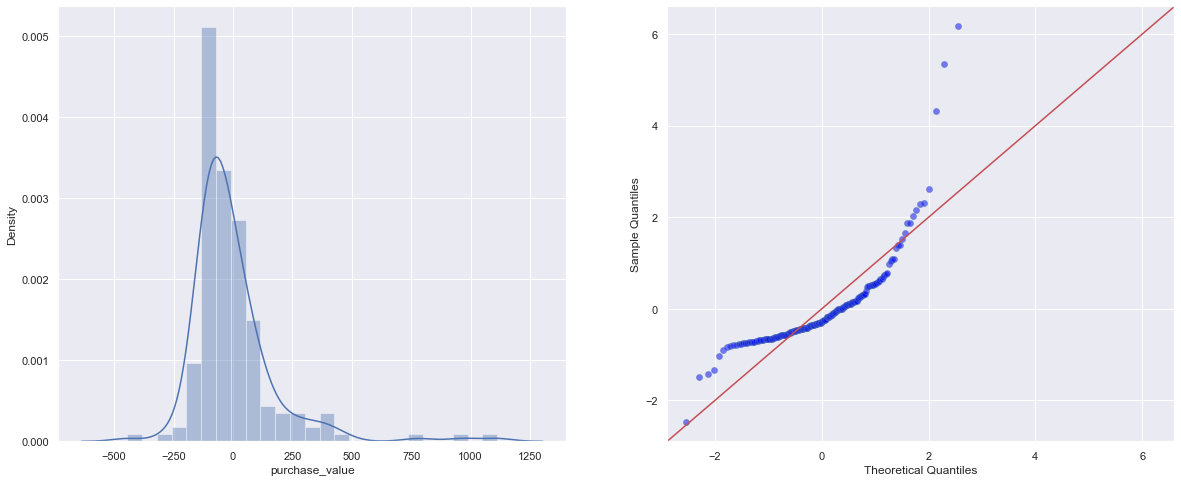

In [24]:
fig, ax = plt.subplots(1,2)
sns.distplot(purchases, bins= 25, hist_kws={'density':True}, ax=ax[0]);
sm.qqplot(purchases, fit=True, line='45', alpha=.5, ax=ax[1]);
fig.show()

É possível observar que forma do gráfico apresenta é enviesada, além disso, no diagrama de probabilidade normal, os dados apresentarem uma variação considerável, rtificando que a nossa distribuição não é normal.

Também podemos calcular **curtose** e **assimetria**, para determinar o quanto a distribuição de dados se afasta da distribuição normal.

In [25]:
print( 'Curtose da distribuição: {}'.format(round(stats.kurtosis(purchases),2)))
print( 'Assimetria da distribuição: {}'.format(round(stats.skew(purchases),2)))

AttributeError: 'numpy.float64' object has no attribute 'kurtosis'

- **Curtose**: descreve o peso das caudas de uma distribuição

A distribuição normal tem uma curtose próxima a 0. Se a curtose for maior que zero, a distribuição terá caudas mais alongadas. Se a curtose for menor que zero, a distribuição será de caudas mais curtas. E nossa curtose é maior que zero.

 - **Assimetria**: mede a assimetria da distribuição

Se a assimetria estiver entre **-0,5 e 0,5**, os dados serão bastante simétricos. Se a assimetria estiver entre **-1 e - 0,5** ou entre **0,5 e 1**, os dados serão moderadamente inclinados. Se a assimetria for **menor que -1** ou **maior que 1**, os dados serão altamente inclinados. E nossa assimetria é **maior que 1**.

In [26]:
purchases

purchase_date
2016-01-01   -106.238993
2016-01-02   -138.173856
2016-01-03   -138.183543
2016-01-04   -151.563772
2016-01-05   -143.150223
                 ...    
2016-06-26      7.402625
2016-06-27    -78.360963
2016-06-28   -101.940906
2016-06-29    -77.042096
2016-06-30      9.928965
Freq: D, Name: purchase_value, Length: 182, dtype: float64

Como estamos lidando com um modelo aditivo, podemos visualizar nossos dados em termos de decomposição da série temporal principal. Assim é possível decompor nossa série temporal em três componentes distintos: **tendência**, **sazonalidade** e **ruído**.

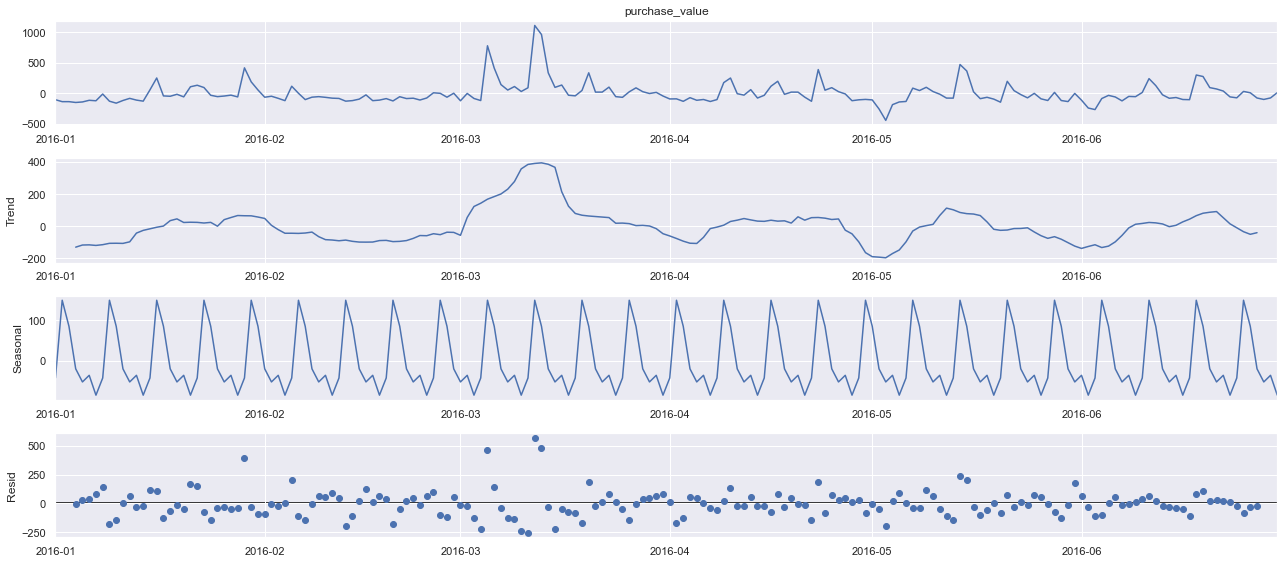

In [27]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(purchases, model='additive')
decomposition.plot()
plt.show()

Em geral, nossa série temporal não apresentam tendência ascendente ou descendente, o maior pico médio de compras parece ser na primeira quinzena de março. O gráfico residual mostra uma alta variação, apresentando períodos de alta variabilidade na série, com destaque para a primeira quinzena de março, inicio de maio e final de maio se estendendo até inicio de junho.

Para tentar inferir o faturamento futuro, vamos aplicar um dos métodos mais usados para previsão de séries temporais, conhecido como **ARIMA**, que significa Média Móvel Integrada Autoregressiva. Os modelos **ARIMA** são indicados com a notação **ARIMA (p, d, q)**. Esses três parâmetros são responsáveis pela sazonalidade, tendência e ruído nos dados.

Modelos ARIMA não sazonais são geralmente denotados como ARIMA($p,d,q$), em que os parâmetros $p$, $d$ e $q$ são números inteiros não negativos, $p$ é a ordem (número de defasagens) do modelo auto-regressivo, $d$ é o grau de diferenciação (o número de vezes em que os dados tiveram valores passados subtraídos) e $q$ é a ordem do modelo de média móvel. Modelos ARIMA sazonais são geralmente denotados como ARIMA($p,d,q$)($P,D,Q)_{m}$, em que $m$ se refere ao número de períodos em cada temporada e $P$, $D$ e $Q$ se referem aos termos de auto-regressão, diferenciação e média móvel para a parte sazonal do modelo ARIMA.[3][4]

Quando dois dos três termos são iguais a zero, o modelo pode ser referido com base no parâmetro diferente de zero, retirando "AR", "I" ou "MA" do acrônimo que descreve o modelo. Por exemplo, ARIMA($1,0,0$) é AR($1$), ARIMA($0,1,0$) é I($1$) e ARIMA($0,0,1$) é MA($1$).

In [19]:
# AR(Autoregression) : p - Utiliza valores numéricos históricos para prever os futuros (Lag's)
# I(Integrated)      : d - Técnica para remover a tendência na serie temporal e facilitar a análise
# MA(Moving Average) : q - Utiliza erros residuais a partir da mádia móvel (O quão distante minhas predições estão da média móvel)

p = d = q = range(0, 4)
pdq          = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 15) for x in list(itertools.product(p, d, q))]

Esta etapa é a seleção de parâmetros para o modelo ARIMA de séries temporais de compras de produtos na Hotmart. Nosso objetivo aqui é usar uma estratégia de *Grid Search* para encontrar o conjunto ideal de parâmetros que produz o melhor desempenho para o nosso modelo.

Para determinar a ordem de um modelo ARIMA não sazonal, um critério útil é o critério de informação de Akaike (AIC).[9].



**NOTA:** Esta etapa pode demorar muito a ser concluída.

In [39]:
%%time

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mdl = sm.tsa.statespace.SARIMAX(purchases, 
                                            order                 = param, 
                                            seasonal_order        = param_seasonal, 
                                            enforce_stationarity  = False, 
                                            enforce_invertibility = False)

            results = mdl.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 15)12 - AIC:2395.181728778748
ARIMA(0, 0, 0)x(0, 0, 1, 15)12 - AIC:2205.2379277142554
ARIMA(0, 0, 0)x(0, 0, 2, 15)12 - AIC:2014.4842930610002
ARIMA(0, 0, 0)x(0, 0, 3, 15)12 - AIC:1828.2705763808333
ARIMA(0, 0, 0)x(0, 1, 0, 15)12 - AIC:2321.495638392676
ARIMA(0, 0, 0)x(0, 1, 1, 15)12 - AIC:2035.3903100793266
ARIMA(0, 0, 0)x(0, 1, 2, 15)12 - AIC:1845.0379540037975
ARIMA(0, 0, 0)x(0, 1, 3, 15)12 - AIC:4541.128953093928
ARIMA(0, 0, 0)x(0, 2, 0, 15)12 - AIC:2281.514823469299
ARIMA(0, 0, 0)x(0, 2, 1, 15)12 - AIC:1942.5408738028964
ARIMA(0, 0, 0)x(0, 2, 2, 15)12 - AIC:1700.7138857101886
ARIMA(0, 0, 0)x(0, 2, 3, 15)12 - AIC:5187.204187540112
ARIMA(0, 0, 0)x(0, 3, 0, 15)12 - AIC:2166.297625664768
ARIMA(0, 0, 0)x(0, 3, 1, 15)12 - AIC:1834.8061516868022
ARIMA(0, 0, 0)x(0, 3, 2, 15)12 - AIC:1584.5200490439843
ARIMA(0, 0, 0)x(0, 3, 3, 15)12 - AIC:nan
ARIMA(0, 0, 0)x(1, 0, 0, 15)12 - AIC:2220.3993509381025
ARIMA(0, 0, 0)x(1, 0, 1, 15)12 - AIC:2207.1885513381067
ARIMA(0, 0, 0

In [33]:

# Auto ARIMA nos ajuda a buscar os melhores parâmetros
fit_arima = auto_arima(purchases, 
                       n_jobs=-1,
                       d=4, 
                       start_p=0, start_q=0, 
                       max_p=4, max_q=4,
                       seasonal=True, 
                       m=6, 
                       D=1, 
                       start_P=0, 
                       start_Q=0, 
                       max_P=4, 
                       max_Q=4, 
                       maxiter=1000, 
                       information_criterion='aic',
                       trace=True, 
                       error_action='ignore', 
                       stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,4,0)(0,1,0)[6]             : AIC=2940.891, Time=0.06 sec
 ARIMA(1,4,0)(1,1,0)[6]             : AIC=2801.072, Time=1.09 sec
 ARIMA(0,4,1)(0,1,1)[6]             : AIC=inf, Time=0.73 sec
 ARIMA(1,4,0)(0,1,0)[6]             : AIC=2843.734, Time=0.06 sec
 ARIMA(1,4,0)(2,1,0)[6]             : AIC=2737.186, Time=1.17 sec
 ARIMA(1,4,0)(3,1,0)[6]             : AIC=2714.611, Time=1.73 sec
 ARIMA(1,4,0)(4,1,0)[6]             : AIC=2714.815, Time=1.57 sec
 ARIMA(1,4,0)(3,1,1)[6]             : AIC=inf, Time=1.76 sec
 ARIMA(1,4,0)(2,1,1)[6]             : AIC=inf, Time=1.06 sec
 ARIMA(1,4,0)(4,1,1)[6]             : AIC=inf, Time=4.55 sec
 ARIMA(0,4,0)(3,1,0)[6]             : AIC=2825.638, Time=0.22 sec
 ARIMA(2,4,0)(3,1,0)[6]             : AIC=2648.171, Time=1.05 sec
 ARIMA(2,4,0)(2,1,0)[6]             : AIC=2668.277, Time=0.72 sec
 ARIMA(2,4,0)(4,1,0)[6]             : AIC=2647.746, Time=1.27 sec
 ARIMA(2,4,0)(4,1,1)[6]             : AIC=inf, Time=2

A saída acima sugere que os parâmetros **(1, 1, 3)** para sazonalidade, tendência e ruído, e **(2, 3, 3, 15)** para a ordem temporal, produzindo o menor valor de **AIC** de **1229.34** assim, vamos tomar esse conjunto de parâmetros como o ideal.

In [47]:
# AIC: 1333.76
# ORDER (3, 3, 3)
# SEASONAL ORDER (3, 3, 2, 15)

# AIC: 1229.34
# ORDER (1, 1, 3)
# SEASONAL ORDER (2, 3, 3, 15)

mdl = sm.tsa.statespace.SARIMAX(purchases,
                                order                 = (1, 1, 3),
                                seasonal_order        = (2, 3, 3, 15))
results = mdl.fit()

O resumo resultante da saída do SARIMAX retorna uma quantidade significativa de informações, mas focaremos nossa atenção na tabela de coeficientes. A coluna **coef** mostra o peso (ou seja, a importância) de cada recurso e como cada um deles afeta a série temporal. A coluna **P>|z|** informa sobre a significância do peso de cada feature. Aqui, a maioria dos pesos tem um valor de **p** menor ou próximo a 0,05, portanto, é razoável considera-los em nosso modelo.

In [48]:
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9981      0.072     13.806      0.000       0.856       1.140
ma.L1         -2.0695      0.020   -106.056      0.000      -2.108      -2.031
ma.L2          1.1686      0.023     51.377      0.000       1.124       1.213
ma.L3         -0.0982      0.013     -7.530      0.000      -0.124      -0.073
ar.S.L15      -0.0630      0.016     -4.005      0.000      -0.094      -0.032
ar.S.L30       0.9291      0.023     41.225      0.000       0.885       0.973
ma.S.L15      -0.9957      0.205     -4.853      0.000      -1.398      -0.594
ma.S.L30      -0.8963      0.106     -8.472      0.000      -1.104      -0.689
ma.S.L45       0.9189      0.070     13.150      0.000       0.782       1.056
sigma2       1.09e+05   2.31e-06   4.72e+10      0.000    1.09e+05    1.09e+05


Vamos executar o diagnóstico do modelo para investigar se existem comportamentos incomuns.

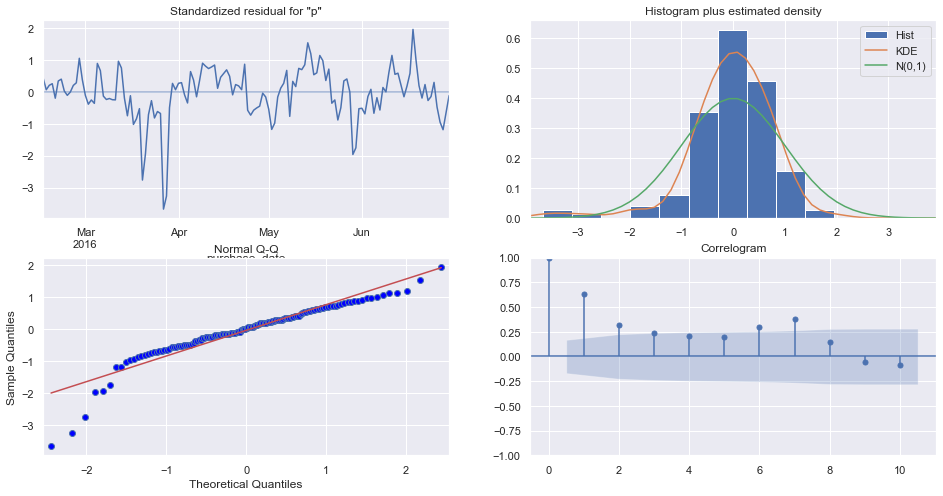

In [49]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

Nossa principal preocupação é garantir que os resíduos de nosso modelo não sejam correlacionados e normalmente distribuídos com média zero. Nesse caso, o diagnóstico do modelo sugere que os resíduos do modelo não são normalmente distribuídos mas são muito próximos, com base nos seguintes insights:

- Os resíduos ao longo do tempo (gráfico superior esquerdo) não mostram nenhuma sazonalidade óbvia como já mencionado anteriormente, e aparentam ser ruídos brancos. Isso é endossado pelo **gráfico de autocorrelação** ou **correlograma**) no canto inferior direito, que mostra que os resíduos da série temporal têm baixa correlação ou uma correlação improvável para o nosso conjunto de dados.


- O gráfico qq no canto inferior esquerdo mostra que a distribuição ordenada de resíduos (pontos azuis), em maioria porém não totalmente, seguem a tendência linear das amostras retiradas de uma distribuição normal padrão com **N(0,1)**. Ou seja, os resíduos não são normalmente distribuídos, mas estão muito próximos apesar de nosso teste de assimetria indicar que os dados estão altamente inclinados.


- No gráfico superior direito, pode-se observar que a linha vermelha do **KDE** segue de perto a linha **N(0,1)** (onde **N(0,1)**) é a notação padrão para uma distribuição normal com média 0 e desvio padrão de 1). Se traçarmos uma linha vertical imaginária é possível perceber que os resíduos estão muito próximos, mas ainda assim não são normalmente distribuídos.

Essas observações nos levam a concluir que nosso modelo produz um ajuste satisfatório que pode nos ajudar a entender nossos dados de séries temporais e prever valores futuros.

No entanto, embora tenhamos um ajuste satisfatório, alguns parâmetros do nosso modelo podem ser alterados para melhorar a previsão. Por exemplo, nossa pesquisa na grade considerou apenas um conjunto restrito de combinações de parâmetros; portanto, podemos encontrar melhores modelos se ampliarmos a pesquisa na grade.

A seguir, vamos exibir as previsões do modelo.

In [50]:
start_month_prediction = '2016-01-01'
end_month_prediction   = '2016-10-01'

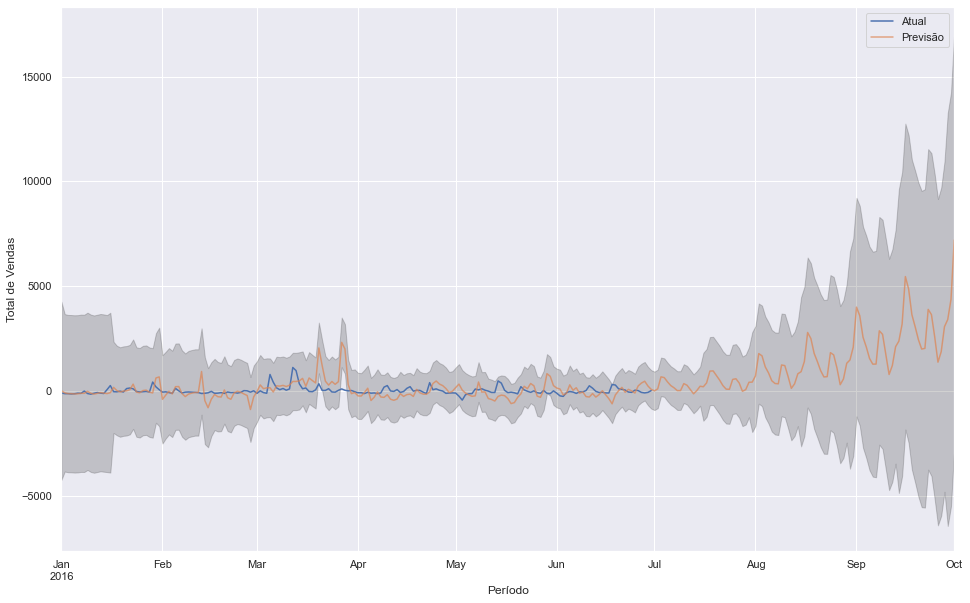

In [51]:
pred = results.get_prediction(start   = pd.to_datetime(start_month_prediction), 
                              end     = pd.to_datetime(end_month_prediction), 
                              dynamic = False)
pred_ci = pred.conf_int()

ax = purchases.plot(label='Atual')
pred.predicted_mean.plot(ax=ax, label='Previsão', alpha=.7, figsize=(16, 10))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Período')
ax.set_ylabel('Total de Vendas')
plt.legend()

plt.show()

Agora, as previsões e o intervalo de confiança associado que geramos agora podem ser usados para entender melhor a série temporal e prever o que esperar. Nossas previsões mostram que a série cronológica deve continuar aumentando a um ritmo constante com um leve tendência de subida. Observe também que a medida que projetamos mais adiante nossas previões, é natural que sejamos menos confiantes em nossos valores. Isso se reflete nos intervalos de confiança gerados pelo nosso modelo (área sombreada), que aumentam à medida que avançamos no futuro.

In [53]:
y_forecasted = pred.predicted_mean
y_truth = purchases['2016-01-01':]

mse = ((y_forecasted - y_truth) ** 2).mean()

print('MSE da previsão {}'.format(round(mse, 2)))

print('RMSE da previsão {}'.format(round(np.sqrt(mse), 2)))

MSE da previsão 171603.07
RMSE da previsão 414.25


O erro quadrático médio da raiz (RMSE) nos diz que nosso modelo foi capaz de prever as vendas diárias de produtos no conjunto de testes dentro de 277.53 das vendas reais. Não é um modelo tão bom, mas não é um modelo tão ruim, devido a limitações computacionais não foi possível utilizar o conjunto de dados em sua totalidade, do contrário, talvez um melhor resultado fosse alcançado.

Por fim salvaremos o nosso modelo.

In [252]:
results.save('models/forecast-model.pkl')

## Melhorias

- Cabe ainda testar outros modelos com metodologias diferentes como por exemplo uma **LSTM**, visto que as **LSTM's** foram projetadas para aprender dependências de longo prazo. No entanto a perda de interpretabilidade seria inevitável dado o caráter "oculto" das redes neurais.
